<a href="https://colab.research.google.com/github/karthik-karalgikar/Aedes/blob/main/unet%2B%2B(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/gdrive/MyDrive')
PATH='./'

In [3]:
#Step 1: Load libraries for the U-net Model

import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [4]:
#Step 2: Import the U-net model
from model_new import *
img_size=(256,256)

In [5]:
n_class=2

In [6]:
mod = Nest_Net(img_size[0],img_size[1],1,1,deep_supervision=True)

In [7]:
#Step 3:Define functions for pre-processing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc


def adjustData(img,mask,flag_multi_class,n_class):

    if(flag_multi_class):
        img /= 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (n_class,))
        for i in range(n_class):

            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img)>1):
        img = img / 255
        mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <=0.5] = 0
        #print(np.shape(mask),np.shape(img))
    return (img,mask)

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,n_class = n_class,save_to_dir = None,target_size = img_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        #'./',
        train_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,n_class)
        yield (img,mask)

def testGenerator(test_path,target_size = img_size,flag_multi_class = True,as_gray = True):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,files[i]),as_gray = as_gray)
        print(files[i])
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        #print(np.max(img))
        yield img


In [8]:
#Step 4: Define function to save the test images
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i] = color_dict[i]

    return img_out


def saveResult(img_path, save_path, npyfile, flag_multi_class=False, num_class=2):
    files = [f for f in sorted(os.listdir(img_path)) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter only image files
    if len(files) != len(npyfile):
        print("Warning: Mismatch in number of files and predictions.")
        return

    for i, item in enumerate(npyfile):
        if flag_multi_class:
            img = labelVisualize(num_class, COLOR_DICT, item)
        else:
            img = np.squeeze(item)  # Assuming item has shape (H, W, 1)
            if img.ndim == 2:
                img = gray2rgb(img)  # Convert grayscale to RGB if necessary

        # Normalize and binarize the image
        img = img_as_ubyte(img > 0.5)

        file_path = os.path.join(save_path, files[i])
        io.imsave(file_path, img)
        print(f"Saved: {file_path}")

def SaveResultwImage(img_path,save_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))

    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.2]=1
        img[img<=0.2]=0

        I = io.imread(os.path.join(img_path,files[i]), as_gray=True)
        I = trans.resize(I,target_size)
        #dst = cv2.addWeighted(img, 0.5, I, 0.5, 0.0)
        img=np.true_divide((I+img),2)
        io.imsave(os.path.join(save_path, files[i]),img)

In [47]:
#Step 5: Define functions to evaluate the output
import sklearn.metrics as sm

def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list):
    """returns precision, recall, IoU and accuracy metrics
	"""
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)

    return prec,rec,IoU,accuracy

def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_validation_metrics(groundtruth,predicted):
    """Return all output metrics. Input is binary images"""

    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    prec,rec,IoU,acc=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
   # print("Precision=",prec, "Recall=",rec, "IoU=",IoU, "acc=",acc, "F1=",f1_score)
    return prec,rec,IoU,acc,f1_score



# def evalResult(gth_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
#     files=sorted(os.listdir(gth_path))
#     #print(files)
#     prec=0
#     rec=0
#     acc=0
#     IoU=0
#     f1_score=0
#     for i,item in enumerate(npyfile):
#         img = item[:,:,0]
#         gth = io.imread(os.path.join(gth_path,files[i]))
#         gth = trans.resize(gth,target_size)
#         if(np.sum(img)>0):
#             img=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
#         if(np.sum(gth)>0):
#             gth=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
#             gth=(gth>0.1).astype(int)
#         #print(np.shape(gth),np.shape(img))
#         p,r,I,a,f=get_validation_metrics(gth[:,:,1],img)
#         if (np.isnan(p)):
#           p=1
#         if (np.isnan(r)):
#           r=1
#         if (np.isnan(f)):
#           f=1
#         if (np.isnan(I)):
#           I=1
#         prec=prec+p
#         rec=rec+r
#         acc=acc+a
#         IoU=IoU+I
#         f1_score=f1_score+f
#     print("Precision=",prec/(i+1), "Recall=",rec/(i+1), "Jac=",IoU/(i+1), "acc=",acc/(i+1), "Dice=",f1_score/(i+1))

def evalResult(gth_path, npyfile, target_size=img_size, flag_multi_class=False, num_class=2):
    files = sorted(os.listdir(gth_path))
    prec, rec, acc, IoU, f1_score = 0, 0, 0, 0, 0
    for i, item in enumerate(npyfile):
        img = item[:, :, 0]
        gth = io.imread(os.path.join(gth_path, files[i]), as_gray=True)
        gth = trans.resize(gth, target_size, preserve_range=True)

        # Ensure both images are the same size
        img = trans.resize(img, target_size, preserve_range=True)

        if np.sum(img) > 0:
            img = np.array(((img - np.min(img)) / np.ptp(img)) > 0.1).astype(float)
        if np.sum(gth) > 0:
            gth = np.array(((gth - np.min(gth)) / np.ptp(gth)) > 0.1).astype(float)
            gth = (gth > 0.1).astype(int)

        # Flatten arrays for metric calculation
        img_flat = img.ravel()
        gth_flat = gth.ravel()

        # Get metrics from the function, which returns four values
        p, r, I, a = get_prec_rec_IoU_accuracy(gth_flat, img_flat)
        if np.isnan(p):
            p = 1
        if np.isnan(r):
            r = 1
        if np.isnan(I):
            I = 1
        if np.isnan(a):
            a = 1
        prec += p
        rec += r
        acc += a
        IoU += I

        # Calculate F1 score separately if not part of the original function
        f1 = 2 * (p * r) / (p + r) if (p + r) != 0 else 0
        f1_score += f1

    print("Precision=", prec / (i + 1), "Recall=", rec / (i + 1), "Jac=", IoU / (i + 1), "acc=", acc / (i + 1), "Dice=", f1_score / (i + 1))


In [10]:
data_gen_args = dict(rotation_range=0.2,
                     #rescale=1./255,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.1,
                    zoom_range=[0.8,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
PATH='./train/'

In [11]:
data_gen = trainGenerator(3,PATH,'MainDataset','Masked_images',data_gen_args, save_to_dir = None)

In [12]:
mod.compile(optimizer = Adam(learning_rate=0.0003), loss = dice_coef_loss, metrics = dice_coef)

In [13]:
hist = mod.fit(data_gen,steps_per_epoch=10,epochs=5,verbose=1)

Found 427 images belonging to 1 classes.
Found 427 images belonging to 1 classes.
Epoch 1/5
10/10 [==============================] - 220s 21s/step - loss: -0.5463 - output_1_loss: -0.1318 - output_2_loss: -0.1396 - output_3_loss: -0.1429 - output_4_loss: -0.1320 - output_1_dice_coef: 0.1318 - output_2_dice_coef: 0.1396 - output_3_dice_coef: 0.1429 - output_4_dice_coef: 0.1320
Epoch 2/5
10/10 [==============================] - 196s 20s/step - loss: -0.5460 - output_1_loss: -0.1325 - output_2_loss: -0.1373 - output_3_loss: -0.1386 - output_4_loss: -0.1377 - output_1_dice_coef: 0.1325 - output_2_dice_coef: 0.1373 - output_3_dice_coef: 0.1386 - output_4_dice_coef: 0.1377
Epoch 3/5
10/10 [==============================] - 185s 19s/step - loss: -0.7464 - output_1_loss: -0.1610 - output_2_loss: -0.1663 - output_3_loss: -0.2121 - output_4_loss: -0.2070 - output_1_dice_coef: 0.1610 - output_2_dice_coef: 0.1663 - output_3_dice_coef: 0.2121 - output_4_dice_coef: 0.2070
Epoch 4/5
10/10 [==========

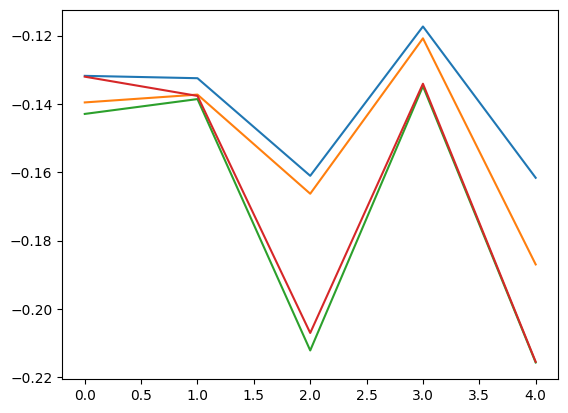

In [14]:
plt.plot(hist.history['output_1_loss'])
plt.plot(hist.history['output_2_loss'])
plt.plot(hist.history['output_3_loss'])
plt.plot(hist.history['output_4_loss'])

In [15]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./test/MainDataset/'))
#Call test generator
test_gen= testGenerator('./test/MainDataset/')
print(n_i)

407


In [16]:
#Return model outcome for each test image
results = mod.predict_generator(test_gen,n_i,verbose=1)

<ipython-input-16-ea1ab214b1d0>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = mod.predict_generator(test_gen,n_i,verbose=1)


aedes (103).jpg
aedes (104).jpg
  5/407 [..............................] - ETA: 15:26aedes (108).jpg
aedes (109).jpg
aedes (11).jpg
aedes (110).jpg
407/407 [==============================] - 646s 2s/step


In [17]:
saveResult('./test/MainDataset/','./pred/',results)

In [18]:
np.shape(results)

(4, 407, 256, 256, 1)

0.954303 0.25013298


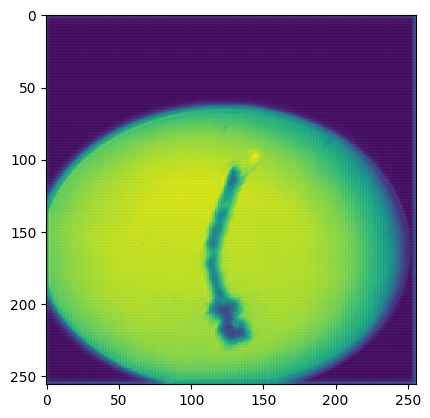

In [19]:
#Lets visualize the STARE predictions
plt.imshow(results[0][50][:,:,0])
print(np.max(results[0]),np.min(results[0]))

In [20]:
def return_Unet_result_layers(files,img_path, results,num):
  I=io.imread(os.path.join(img_path,files[num]), as_gray=True)
  I = trans.resize(I,img_size)
  pred0=(results[0][num][:,:,0]>0.5).astype(int)
  pred1=(results[1][num][:,:,0]>0.5).astype(int)
  pred2=(results[2][num][:,:,0]>0.5).astype(int)
  pred3=(results[3][num][:,:,0]>0.5).astype(int)
  f, axarr = plt.subplots(2,2)
  axarr[0,0].imshow(np.true_divide((I+pred0),2))
  axarr[0,1].imshow(np.true_divide((I+pred1),2))
  axarr[1,0].imshow(np.true_divide((I+pred2),2))
  axarr[1,1].imshow(np.true_divide((I+pred3),2))
  return pred2,pred3

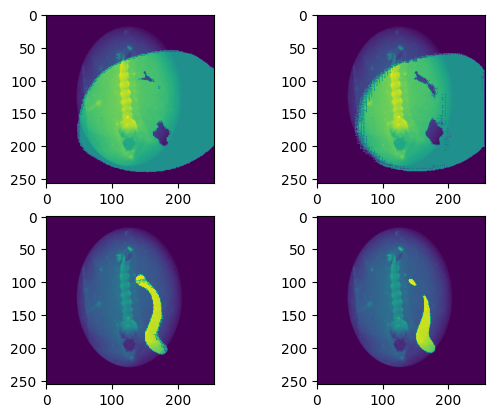

In [21]:
pred2,pred3=return_Unet_result_layers(os.listdir('./test/MainDataset/'),'./test/MainDataset/',results,20)

In [22]:
get_validation_metrics(pred3,pred2)

(0.6654526534859522,
 0.9418262150220913,
 0.6391804097951025,
 0.988983154296875,
 0.7798780487804878)

In [48]:
evalResult('./test/Masked_images/',results)

Precision= 0.07749087547995542 Recall= 0.15945599354114523 Jac= 0.037000835536112664 acc= 0.8445281982421875 Dice= 0.07064317954990355


In [28]:
evalResult('./test/Masked_images/',results[1])

Precision= 0.1064982351963483 Recall= 0.8379743519573953 Jac= 0.10380793663908962 acc= 0.4719850882265433 Dice= 0.18240186666367317


In [29]:
evalResult('./test/Masked_images/',results[2])

Precision= 0.2225423993682022 Recall= 0.14994953010366258 Jac= 0.09655543018368512 acc= 0.9052206503378378 Dice= 0.16597345000304733


In [30]:
evalResult('./test/Masked_images/',results[3])

Precision= 0.221732458517074 Recall= 0.08874950428986614 Jac= 0.06374849920402806 acc= 0.9163955201095094 Dice= 0.11326240176093597


In [31]:
evalResult('./test/Masked_images/',results[0])

Precision= 0.10539247882731502 Recall= 0.8553010489317697 Jac= 0.10331291044031488 acc= 0.46038207257994856 Dice= 0.18172227921416442


In [59]:
# def print_top2bottom(gth_path, img_path, npyfile, target_size=img_size, flag_multi_class=False, num_class=2):
#     files = sorted(os.listdir(gth_path))
#     for i, item in enumerate(npyfile):
#         print(i)
#         img = item[:, :, 0]
#         gth = io.imread(os.path.join(gth_path, files[i]), as_gray=True)
#         gth = trans.resize(gth, target_size)

#         I = io.imread(os.path.join(img_path, files[i]), as_gray=True)
#         I = trans.resize(I, img_size)

#         img = np.array(((img - np.min(img)) / np.ptp(img)) > 0.1).astype(float)
#         gth = np.array(((gth - np.min(gth)) / np.ptp(gth)) > 0.1).astype(float)
#         gth = (gth > 0.9).astype(int)

#         p, r, j, a, f = get_validation_metrics(gth, img)
#         print(p, r, j, a, f)

#         fin_image = np.zeros((gth.shape[0], gth.shape[1], 3))
#         fin_image[:, :, 0] = gth  # Red channel for ground truth
#         fin_image[:, :, 1] = I   # Green channel for input image
#         fin_image[:, :, 2] = img  # Blue channel for prediction

#         plt.imshow(fin_image)
#         plt.show()

#         if j > 0.7:  # Break after displaying the first high-performing image
#             break

def print_top2bottom(gth_path, img_path, npyfile, target_size=img_size, flag_multi_class=False, num_class=2):
    files = sorted(os.listdir(gth_path))
    for i, item in enumerate(npyfile):
        print(i)
        img = item[:, :, 0]
        gth = io.imread(os.path.join(gth_path, files[i]), as_gray=True)
        gth = trans.resize(gth, target_size)

        I = io.imread(os.path.join(img_path, files[i]), as_gray=True)
        I = trans.resize(I, img_size)

        img = np.array(((img - np.min(img)) / np.ptp(img)) > 0.1).astype(float)
        gth = np.array(((gth - np.min(gth)) / np.ptp(gth)) > 0.1).astype(float)
        gth = (gth > 0.9).astype(int)

        p, r, j, a, f = get_validation_metrics(gth, img)
        print(p, r, j, a, f)


In [60]:
print_top2bottom('./test/Masked_images/','./test/MainDataset/', results[3])

0
0.09953917050691244 0.043010752688172046 0.03096330275229358 0.94842529296875 0.060066740823136816
1
0.03133903133903134 0.014816810344827586 0.01016260162601626 0.9182586669921875 0.02012072434607646
2
0.11281265952016335 0.07122139864647116 0.04565172485023755 0.92950439453125 0.08731726590280521
3
0.0 0.0 0.0 0.95086669921875 0.0
4
0.1553470919324578 0.12325096754986603 0.07379679144385026 0.92071533203125 0.13745019920318724
5
0.0 0.0 0.0 0.964324951171875 0.0
6
0.15434537246049662 0.17905073649754502 0.09038334434897555 0.9160003662109375 0.16578269434762843
7
0.39686924493554326 0.1716447630426125 0.1361339229311434 0.9582672119140625 0.23964414790102864
8
0.024050632911392405 0.006874095513748191 0.005374823196605375 0.94635009765625 0.010692177827799663
9
0.0 0.0 0.0 0.9607696533203125 0.0
10
0.08211920529801324 0.050798852929127405 0.03240135876665796 0.9434967041015625 0.06276891926094659
11
0.0009237875288683603 0.0007680491551459293 0.0004195510803440319 0.927291870117187